In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

2017-08-23
2016-08-23


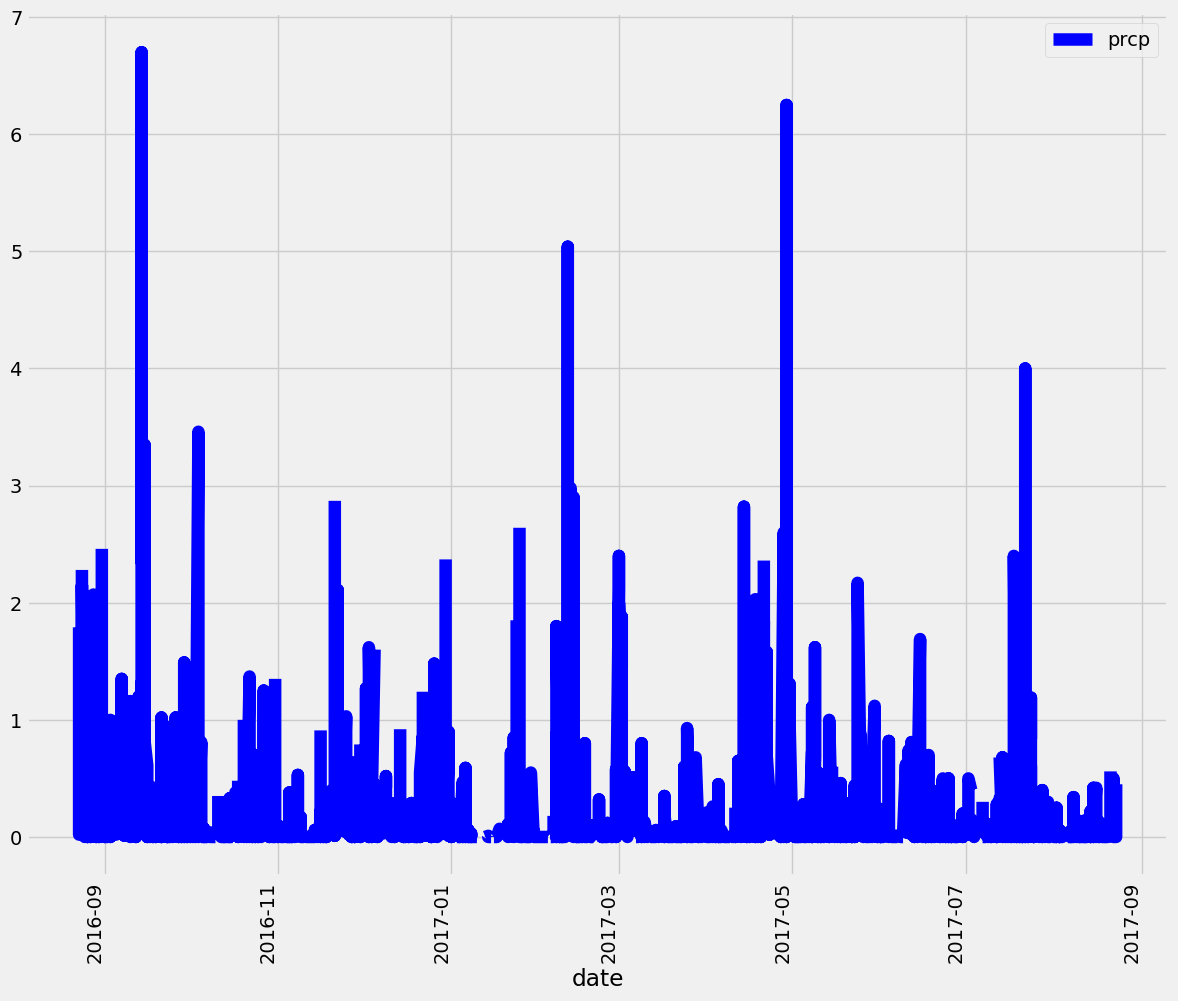

In [109]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

results_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date = list(np.ravel(results_date))[0]
print(str_date)

# Calculate the date one year from the last date in data set.
date_range = (dt.date(2017,8,23)) - (dt.timedelta(days=365))
print(date_range)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_range)
#Check
precip_scores.first()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

precip_score_pd = pd.DataFrame(precip_scores)
precip_score_pd.head()

# Sort the dataframe by date

precip_score_pd['date'] = pd.to_datetime(precip_score_pd['date'])
precip_pd = precip_score_pd.sort_values(by=['date'])
precip_pd.head(10)

precip_pd = precip_pd.set_index(precip_pd['date'])
precip_pd.head()

# Use Pandas Plotting with Matplotlib to plot the data
fontsize=12
ax=precip_pd.prcp.plot(color='b',figsize=(12,10),legend=True,linewidth=9.0,grid=True)
plt.setp(ax.get_xticklabels(), visible=True)
plt.tight_layout()
plt.xlabel("date")
plt.xticks(rotation=90)
plt.show()




In [73]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_pd.describe()

,date,prcp
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_Measurment=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

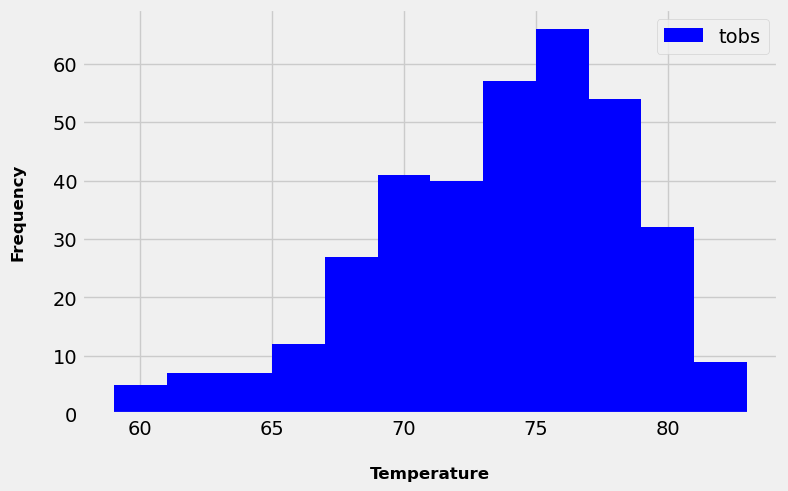

In [113]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_date = (
    session.query(Measurement.date)
    .order_by(Measurement.date.desc())
    .filter(Measurement.station == station_Measurment[0][0])
    .first()
)
str_date = list(np.ravel(results_date))[0]
latest_date = dt.datetime.strptime(str_date, "%Y-%m-%d")
year_back = latest_date - dt.timedelta(days=366)

results_temp = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == station_Measurment[0][0])
    .filter(Measurement.date >= year_back)
    .all()
)
df_results = pd.DataFrame(results_temp)




#Plotting Histogram
hist = df_results.tobs.hist(bins=12,figsize=(8,5), color='b', zorder=2,legend=True,)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)
hist.set_xlabel("Temperature", labelpad=20, weight='bold', size=12)

plt.show()


# Close Session

In [23]:
# Close Session
session.close()